## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
congress_tweets = pd.read_csv("116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets = congress_tweets.sample(n=10000, random_state=1).reset_index(drop=True)
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. http...,Val Demings,Rep,3-Jan-17,3/12/1957,F,FL,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447"
1,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,M,GA,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688"
2,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,2,Republican,"684,872","380,494","394,409","647,744"
3,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,M,FL,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447"
4,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,I understand the VA often has problems recruit...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,M,CA,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958"


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [3]:
#remove missing values/reset index
congress_tweets = congress_tweets.dropna(subset = ['text']).reset_index()
congress_tweets['text_original'] = congress_tweets['text']
congress_tweets.head()

,index,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,text_original
0,0,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. http...,Val Demings,Rep,3-Jan-17,3/12/1957,F,FL,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447",Thank you for testifying today Mr. Blake. http...
1,1,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,M,GA,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688",My Twitter Town Hall on healthcare has begun a...
2,2,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,2,Republican,"684,872","380,494","394,409","647,744",Scipio Jones‘ fight for civil rights and equal...
3,3,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,M,FL,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447",There is no better time to #ActOnClimate than ...
4,4,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,I understand the VA often has problems recruit...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,M,CA,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958",I understand the VA often has problems recruit...


In [4]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    nlp.Defaults.stop_words.add("rt")
    nlp.Defaults.stop_words.add("qt")
    nlp.Defaults.stop_words.add("amp")
    nlp.Defaults.stop_words.add("RT")
    nlp.Defaults.stop_words.add("QT")
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [5]:
import re

#deal with URLS
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+'"")
    return url_pattern.sub(r'', text)

congress_tweets['text'] = congress_tweets['text'].apply(remove_urls)

In [6]:
#deal with emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                            u"\u200d"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

congress_tweets['text'] = congress_tweets['text'].apply(remove_emoji)

In [7]:
#tokenization
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x))
congress_tweets['tokens']

0       [Thank, testifying, today, Mr, Blake,  , JRBla...
1       [My, Twitter, Town, Hall, healthcare, begun, I...
2       [Scipio, Jones, ‘, fight, civil, rights, equal...
3       [There, better, time, ActOnClimate, EarthDay, ...
4       [I, understand, VA, problems, recruiting, qual...
                              ...                        
9995    [Republicans, spent, weeks, funds, dried, aski...
9996    [TheBlackCaucus, To, forever, Black, Panther, ...
9997    [Our, Bahamian, brothers, sisters, dire, need,...
9998    [Heartbreaking, realDonaldTrump, cruel, polici...
9999    [CoinDesk, RepDarrenSoto, RepDavid, Schweikert...
Name: tokens, Length: 10000, dtype: object

In [8]:
#Change Independent Senators who caucus with Democrats to party==Democrat
congress_tweets.loc[congress_tweets.party == "Independent", "party"] = "Democrat"

In [9]:
# Run this line to save your pre-processed data so that you don't have to keep re-running it every time you work on the notebook
# congress_tweets.to_csv('congress_tweets_preprocessed.csv')

In [ ]:
# Run this line to read back in your saved pre-processed data rather than re-running the lines above
# congress_tweets = pd.read_csv('congress_tweets_preprocessed.csv')

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

In [ ]:
#I believe we shrank the data in the lab before topic modeling so 
#it might be useful to do it here, too for sake of faster running..
#I tried it without shrinking first because topics weren't distinct enough with smaller data
#congress_tweets = congress_tweets[:1000]

### EDA 1: Topic Modeling

In [10]:
X = congress_tweets['text']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)

tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()

In [11]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5, max_iter=20, random_state=0)
lda = lda.fit(dense_matrix)

/Applications/anaconda3/envs/geo/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [12]:
lda2 = LatentDirichletAllocation(n_components=10, max_iter=20, random_state=0)
lda2 = lda2.fit(dense_matrix)

/Applications/anaconda3/envs/geo/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


In [13]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [14]:
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 20)


Topic #0:
  

 
 today health act need people house covid19 work trump help time american president thank new congress americans

Topic #1:
hong kong miners hatred dday beaches holocaust outdoor patriotic pridemonth marijuana delaware rhetoric defund recreation netneutrality venezuela pulse wecount protesters

Topic #2:
de la indiana taiwan donate congresswoman en houseforeigngop y prolife para affects repbeatty el treaty   
 bringbackourgirls legion su fans

Topic #3:
de el en la y para corps telehealth los que comment model missing las michaelcburgess terminate del couple ksleg ks02

Topic #4:
impeachment president mueller trump barr inquiry investigation ukraine defendourdemocracy de evidence   happy report attorney witnesses trial oath whistleblower celebrating



/Applications/anaconda3/envs/geo/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [15]:
tf_feature_names = tf.get_feature_names()
print_top_words(lda2, tf_feature_names, 20)


Topic #0:
mobile arkansas helpful era 21st bay robust feedback markup powerful extraordinary transportdems mask utah boeing hotline navigating precautions stevescalise repandybiggsaz

Topic #1:
miners pensions vaccine canada patriotic coal immunity comment retired dedication openings improving sept seekers moves active ballot pioneer americanminersact treating

Topic #2:
weekly alabama sbagov fridayswithfrank coffee quid collection failing telehealth sondland blacklivesmatter update misinformation prayer blame fault join shot negative vaccine

Topic #3:
cspan robocalls missing earth grandchildren traced homelanddems seanhannity chuck 25th wilson turkey academy sovereignty gopoversight suffrage penalties tornado insulin admitted

Topic #4:
disparities birthday happy hanukkah repbarbaralee maternal disappointed bringbackourgirls cancer pregnancy source happiness damaging regular complications blessed celebrating wishing lowering statements

Topic #5:
  

 
 today trump president health 

### EDA 2

### Word Clouds

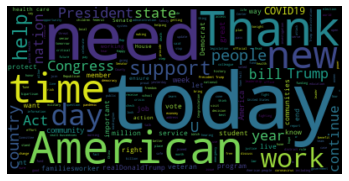

In [31]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import scattertext as st

# Generic wordcloud

text = ' '.join(congress_tweets['tokens'].map(lambda text: ' '.join(text)))
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [32]:
rep = congress_tweets[congress_tweets['party']=='Republican']
dem = congress_tweets[congress_tweets['party']=='Democrat']
r_text = ' '.join(rep['tokens'].map(lambda text: ' '.join(text)))
d_text = ' '.join(dem['tokens'].map(lambda text: ' '.join(text)))

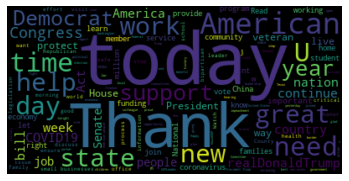

In [33]:
# Republican wordcloud

wordcloud = WordCloud().generate(r_text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

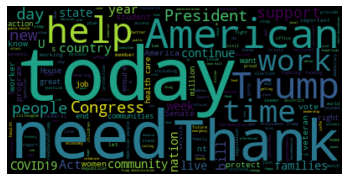

In [34]:
# Democrat wordcloud

wordcloud = WordCloud().generate(d_text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### Word/Character Counts

In [26]:
congress_tweets['tweet_len'] = congress_tweets['text_original'].apply(len)
congress_tweets['word_count'] = congress_tweets['text_original'].apply(lambda x: len(str(x).split()))
#congress_tweets['text'] = congress_tweets['text'].map(lambda text: ' '.join(text))
#congress_tweets['polarity'] = congress_tweets['text'].map(lambda text: TextBlob(text).sentiment.polarity)
#congress_tweets['subjectivity'] = congress_tweets['text'].map(lambda text: TextBlob(text).sentiment.subjectivi

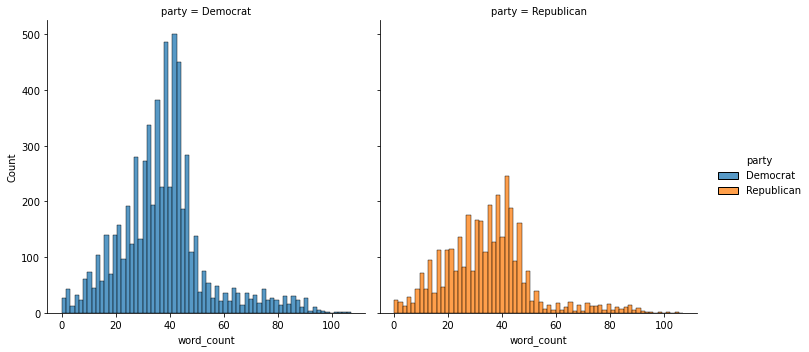

In [27]:
sns.displot(congress_tweets, x="word_count", hue = "party", col = "party")
plt.show()

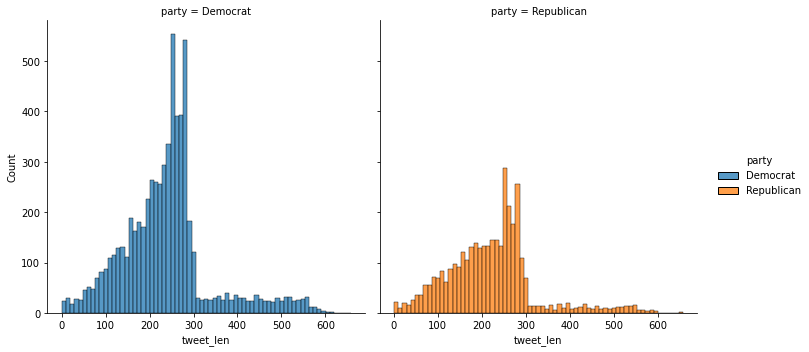

In [28]:
sns.displot(congress_tweets, x ="tweet_len", hue = "party", col = "party")
plt.show()

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [ ]:
# Engineered Features
...

### Bag-of-words or Tf-idf

NOTE: This section outputs two numpy matrices: bow_matrix and tfidf_matrix. The instructions above say we need to create three dataframes. I am not sure exactly what should go in each dataframe.

In [24]:
# BOW
bow_vector = CountVectorizer(tokenizer = rem_punc_stop, ngram_range=(1,1))
bow_matrix = bow_vector.fit_transform(congress_tweets['text'])
bow_matrix = bow_matrix.todense()

In [22]:
bow_matrix

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 2, 0, ..., 0, 0, 0]])

In [23]:
bow_feature_names = bow_vector.get_feature_names()
bow_feature_names[0:10]

['\n',
 '\n\n',
 '\n\n\n',
 '\n\n\n\n',
 '\n\n\n\n\n\n\n\n\n\n\n         ',
 '\n\n\n\n ',
 '\n\n ',
 '\n\n \n\n',
 '\n\n  ',
 '\n\n  \n\n']

In [25]:
type(bow_matrix)

numpy.matrix

In [29]:
bow_matrix.shape

(10000, 27070)

In [26]:
# This may be redundant with the tfidf part of the ETA section

tfidf_vector = TfidfVectorizer(tokenizer = rem_punc_stop)
tfidf_matrix = tfidf_vector.fit_transform(congress_tweets['text'])
tfidf_matrix = tfidf_matrix.todense()
tfidf_matrix

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.16228228, 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [30]:
type(tfidf_matrix)

numpy.matrix

In [28]:
tfidf_matrix.shape

(10000, 27070)

In [27]:
tfidf_feature_names = tfidf_vector.get_feature_names()
tfidf_feature_names

['\n',
 '\n\n',
 '\n\n\n',
 '\n\n\n\n',
 '\n\n\n\n\n\n\n\n\n\n\n         ',
 '\n\n\n\n ',
 '\n\n ',
 '\n\n \n\n',
 '\n\n  ',
 '\n\n  \n\n',
 '\n\n  \n\n ',
 '\n\n   ',
 '\n\n   \n\n',
 '\n\n    ',
 '\n ',
 '\n \n',
 '\n \n ',
 '\n \n  ',
 '\n \n                 \n             ',
 '\n  ',
 '\n   ',
 '\n   \n',
 '\n    ',
 '\n    \n',
 '\n     ',
 '\n       ',
 '\n         ',
 '\n            ',
 '\n              ',
 '\n\xa0\n',
 ' ',
 ' \n',
 ' \n\n',
 ' \n\n ',
 ' \n ',
 ' \n \n',
 '  ',
 '  \n',
 '  \n\n',
 '  \n\n  ',
 '  \n ',
 '  \n                ',
 '   ',
 '   \n',
 '   \n\n',
 '    ',
 '    \n',
 '     ',
 '      ',
 '       \n          ',
 '        \n\n',
 '           ',
 '               ',
 '                 ',
 '                                    ',
 '0',
 '0001',
 '01',
 '0184',
 '019119',
 '026',
 '03',
 '0312',
 '0600pm',
 '080',
 '1',
 '10',
 '100',
 '1000',
 '10000',
 '100000',
 '1000000000000',
 '1000am',
 '1000am1200pm',
 '1000s',
 '1000th',
 '10017',
 '100300',
 '100

### Word Embedding

In [ ]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

#model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [ ]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.vocab]
    return np.mean(model[doc], axis=0)

In [ ]:
# embedding based featurization
...

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [ ]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])
...

### Two Combined Models

In [ ]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
...

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Your Answer Here**

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Your Answer Here**

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**Your Answer Here**

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Your Answer Here**